# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score



%matplotlib inline

In [2]:
!pip install imblearn


In [3]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [9]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

In [10]:
df['sales_channel'].value_counts()

Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64

<AxesSubplot:title={'center':'Sales channel'}, xlabel='sales_channel', ylabel='count'>

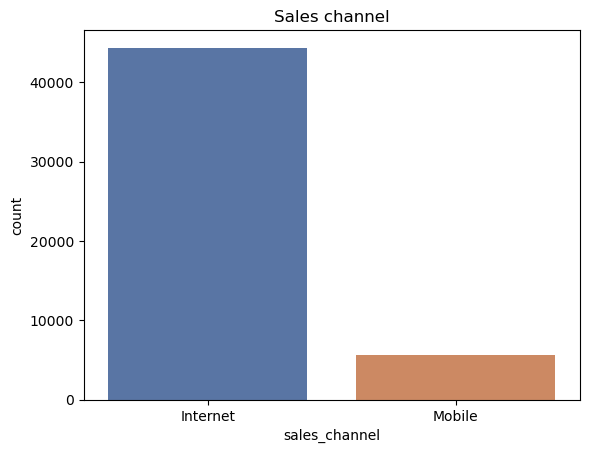

In [11]:
plt.title('Sales channel')
sns.countplot(x=df['sales_channel'], data=df, palette='deep')

In [12]:
df['trip_type'].value_counts()

RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64

<AxesSubplot:title={'center':' Trip type'}, xlabel='trip_type', ylabel='count'>

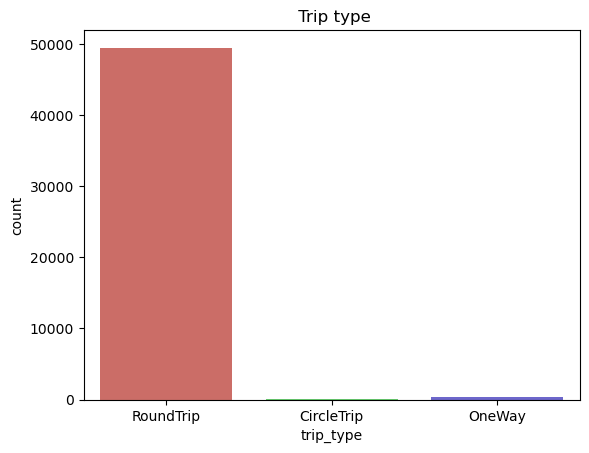

In [13]:
plt.title(' Trip type')
sns.countplot(x=df['trip_type'], data = df, palette='hls')

In [14]:
df['flight_day'].value_counts()

1    8102
3    7674
2    7673
4    7424
5    6761
7    6554
6    5812
Name: flight_day, dtype: int64

<AxesSubplot:title={'center':'Flight day'}, xlabel='flight_day', ylabel='count'>

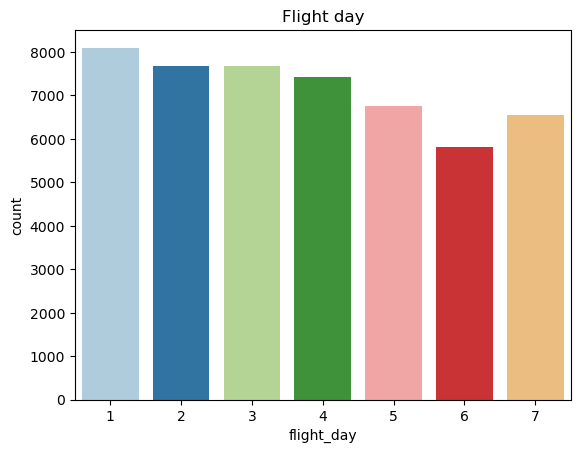

In [15]:
plt.title('Flight day')
sns.countplot(x=df['flight_day'], data=df, palette='Paired')

In [16]:
df['booking_origin'].value_counts().iloc[:25]

Australia         17872
Malaysia           7174
South Korea        4559
Japan              3885
China              3387
Indonesia          2369
Taiwan             2077
Thailand           2030
India              1270
New Zealand        1074
Singapore          1044
United States       456
Vietnam             388
Macau               304
Hong Kong           295
Philippines         266
United Kingdom      173
Brunei              167
Cambodia            132
(not set)            84
Sri Lanka            73
France               59
Italy                58
Canada               57
Germany              57
Name: booking_origin, dtype: int64

<AxesSubplot:title={'center':'Booking origin'}, xlabel='booking_origin', ylabel='count'>

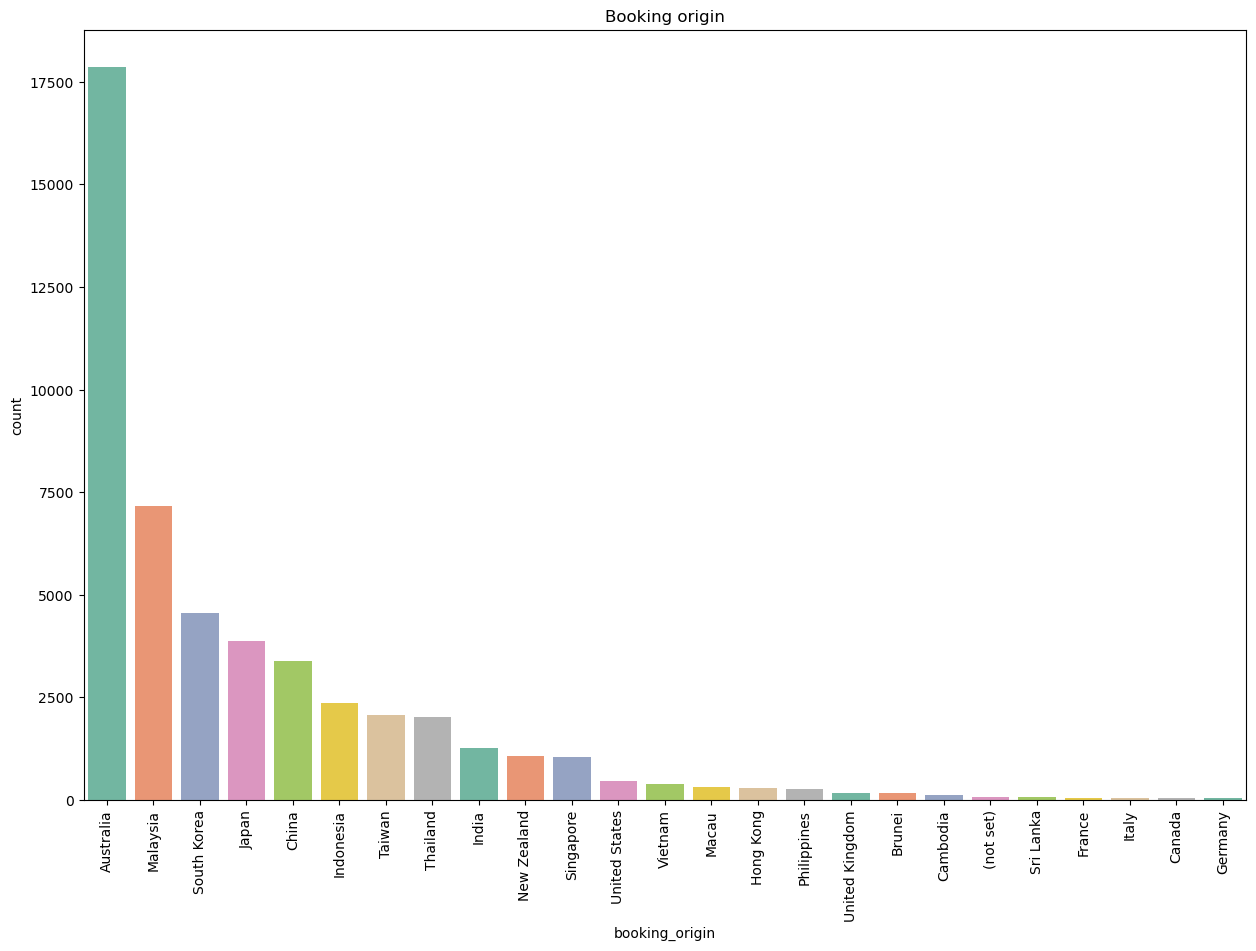

In [17]:
plt.figure(figsize=(15,10))
plt.title('Booking origin')
plt.xticks(rotation=90)
sns.countplot(x=df['booking_origin'].sort_index(), data=df, order = df['booking_origin'].value_counts().iloc[:25].index, palette = 'Set2')

In [18]:
df['wants_extra_baggage'].value_counts()

1    33439
0    16561
Name: wants_extra_baggage, dtype: int64

<AxesSubplot:xlabel='wants_extra_baggage', ylabel='count'>

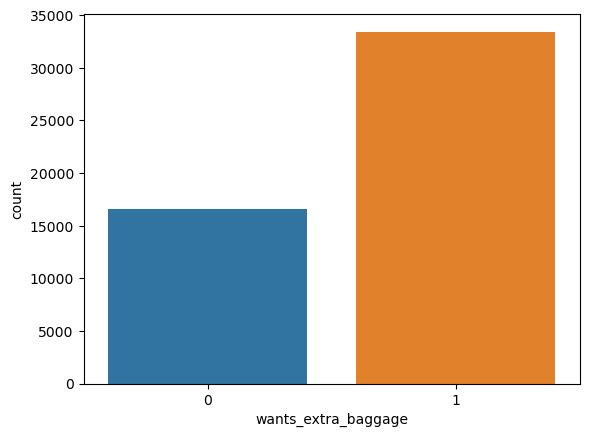

In [19]:
sns.countplot(x=df['wants_extra_baggage'], data=df, palette='tab10')

In [20]:
df['wants_preferred_seat'].value_counts()

0    35152
1    14848
Name: wants_preferred_seat, dtype: int64

<AxesSubplot:xlabel='wants_preferred_seat', ylabel='count'>

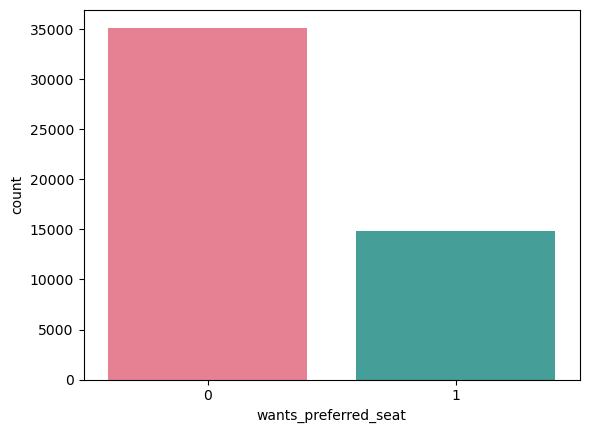

In [21]:
sns.countplot(x=df['wants_preferred_seat'], data=df, palette = 'husl')

In [22]:
df['wants_in_flight_meals'].value_counts()

0    28643
1    21357
Name: wants_in_flight_meals, dtype: int64

<AxesSubplot:xlabel='wants_in_flight_meals', ylabel='count'>

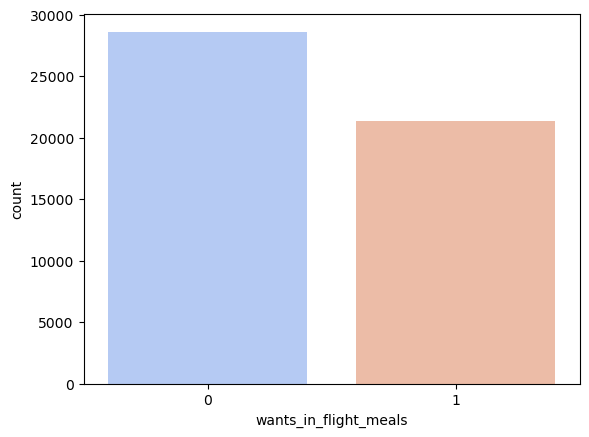

In [23]:
sns.countplot(x=df['wants_in_flight_meals'], data=df, palette = 'coolwarm')

In [24]:
df['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

<AxesSubplot:title={'center':'Booking status'}, xlabel='booking_complete', ylabel='count'>

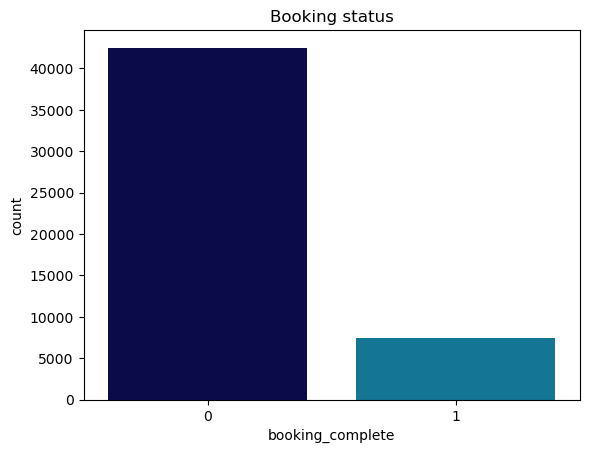

In [25]:
plt.title('Booking status')
sns.countplot(x=df['booking_complete'], data=df, palette='ocean')

In [26]:
df['route'].value_counts().iloc[:25]

AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
ICNSYD     695
DMKPER     679
DPSICN     666
DMKOOL     655
MELPEN     649
MELTPE     644
SGNSYD     614
DMKSYD     532
COKSYD     511
COKMEL     474
CMBMEL     465
HNDPEN     442
PENPER     437
DPSPVG     417
CGKICN     414
JHBKTM     409
CGKHND     389
HKTICN     375
PENSYD     369
PERSGN     361
Name: route, dtype: int64

In [27]:
df['num_passengers'].value_counts()

1    31352
2    12804
3     2941
4     1784
5      561
6      289
7      114
8       89
9       66
Name: num_passengers, dtype: int64

<AxesSubplot:title={'center':' Number of passangers'}, xlabel='num_passengers', ylabel='count'>

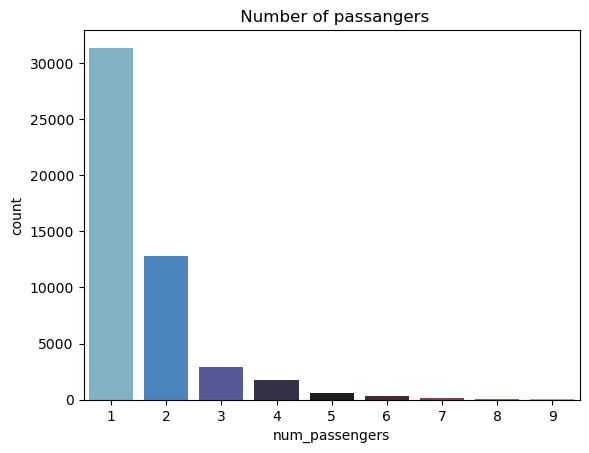

In [28]:
plt.title(' Number of passangers')
sns.countplot(x=df['num_passengers'], data = df, palette='icefire')

## Modeling

In [29]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [30]:
#X.dtypes

In [31]:
#for colname in X.select_dtypes("object"):
    #X[colname], _ = X[colname].factorize()
     

In [32]:
#X.dtypes

In [33]:
df['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

<AxesSubplot:xlabel='booking_complete', ylabel='count'>

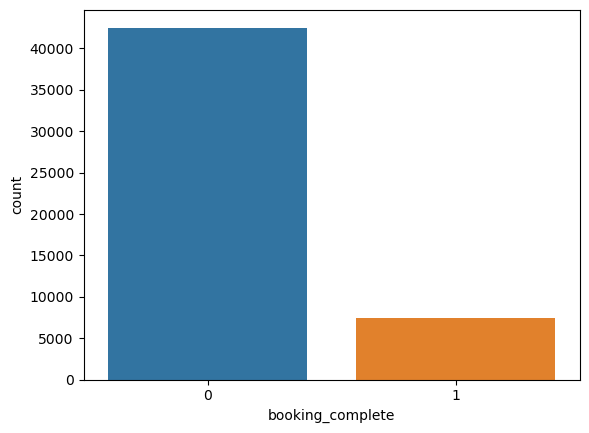

In [34]:
sns.countplot(x=df['booking_complete'])

As can be seen in avbove cell the dataset is inbalanced. It'd skew the splitting and training results. 

In [35]:
#cat_variables = ['sales_channel', 'trip_type', 'route', 'booking_origin']

In [36]:
#One hot encoding
#df = pd.get_dummies(data=df, prefix= cat_variables, columns= cat_variables)

## Standard Random Forest

In [37]:
# Normalize the data set
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

In [38]:
#X = df.drop('booking_complete', axis=1)
X = df.drop('booking_complete', axis=1)
X= pd.get_dummies(X)
X = scale(X)

y = df['booking_complete']
#y = df['booking_complete']





In [79]:
mic = mutual_info_classif(X,y)
mic = pd.Series(mic, name = 'MIC Scores', index=X.columns)
mic = mic.sort_values(ascending=False)
mic

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ValueError: could not convert string to float: 'Internet'

In [40]:
%%time
RFC = RandomForestClassifier(n_estimators=200, random_state =42)
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scoring = ('precision', 'recall', 'f1')
scores = cross_validate(RFC, X, y, cv=cv, scoring=scoring)

#Fitting the model
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)
y_real = y_test.values

print(classification_report(y_real, y_pred))

print('ACCURACY: ',round(accuracy_score(y_real,y_pred)*100,2))
print('AUC score: ',round(roc_auc_score(y_real,y_pred),2))


              precision    recall  f1-score   support

           0       0.87      0.98      0.92      8520
           1       0.52      0.13      0.21      1480

    accuracy                           0.85     10000
   macro avg       0.69      0.56      0.57     10000
weighted avg       0.81      0.85      0.81     10000

Wall time: 27min 33s


C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


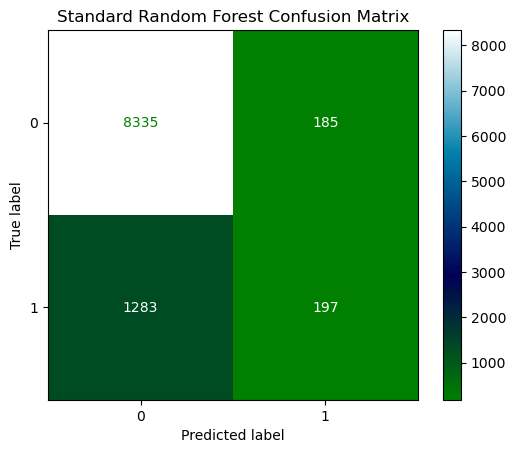

In [41]:
fig = plot_confusion_matrix(RFC, X_test, y_test,  cmap='ocean')
plt.title('Standard Random Forest Confusion Matrix')
plt.show()

In [42]:
print('ACCURACY: ',round(accuracy_score(y_real,y_pred)*100,2))

ACCURACY:  85.32


## XGBoost

In [69]:
%%time

XGB = XGBClassifier()
XGB.fit(X_train, y_train)

y_pred = XGB.predict(X_test)

y_real = y_test.values

print(classification_report(y_real, y_pred))
print('ACCURACY: ',round(accuracy_score(y_real,y_pred)*100,2))
print('AUC score: ',round(roc_auc_score(y_real,y_pred),2))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.55      0.09      0.16      1480

    accuracy                           0.85     10000
   macro avg       0.71      0.54      0.54     10000
weighted avg       0.82      0.85      0.81     10000

ACCURACY:  85.47
AUC score:  0.54
Wall time: 29 s


C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


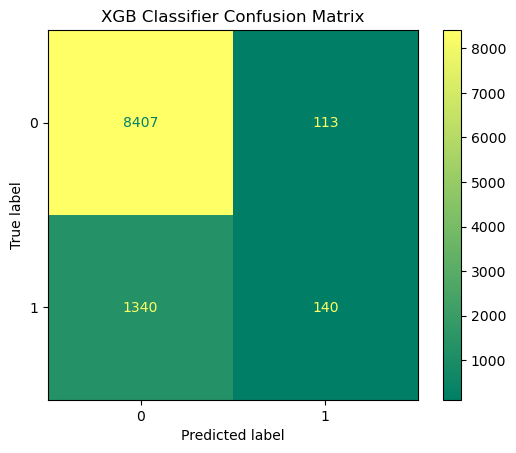

In [44]:
fig = plot_confusion_matrix(XGB, X_test, y_test,  cmap='summer')
plt.title('XGB Classifier Confusion Matrix')
plt.show()

## Undersampling 

In [45]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [46]:
under_sampler = RandomUnderSampler(random_state=42)
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

X_us, y_us = under_sampler.fit_resample(X,y)

In [47]:
print(X_us.shape)
print(y_us.shape)

(14956, 13)
(14956,)


In [48]:
def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X_us)
    return X_us

In [49]:
X_us= pd.get_dummies(X_us)
X_us = scale(X_us)


In [50]:
X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X_us, y_us, test_size=0.2, random_state=42)

In [71]:
%%time
RFC_us = RandomForestClassifier(n_estimators=200, random_state =42)
#cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#scoring = ('precision', 'recall', 'f1')
#scores = cross_validate(RFC, X_us, y_us, cv=cv, scoring=scoring)

#Fitting the model
RFC_us.fit(X_us_train, y_us_train)
y_us_pred = RFC_us.predict(X_us_test)
y_us_real = y_us_test.values

print(classification_report(y_us_real, y_us_pred))
print('ACCURACY: ',round(accuracy_score(y_us_real,y_us_pred)*100,2))
print('AUC score: ',round(roc_auc_score(y_us_real,y_us_pred),2))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1522
           1       0.70      0.74      0.72      1470

    accuracy                           0.72      2992
   macro avg       0.72      0.72      0.72      2992
weighted avg       0.72      0.72      0.72      2992

ACCURACY:  71.66
AUC score:  0.72
Wall time: 13.6 s


C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


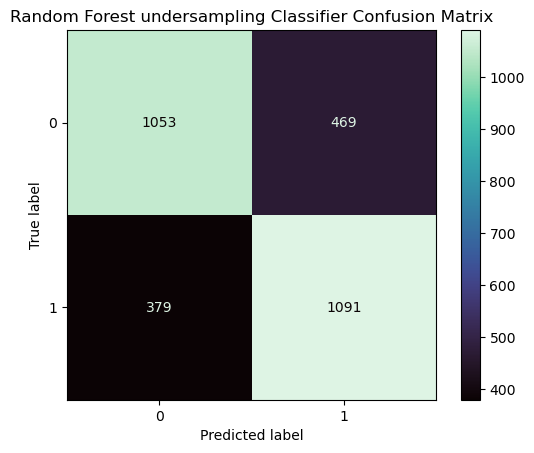

In [52]:
fig = plot_confusion_matrix(RFC_us, X_us_test, y_us_test,  cmap='mako')
plt.title('Random Forest undersampling Classifier Confusion Matrix')
plt.show()

In [72]:
%%time

XGB_us = XGBClassifier()
XGB_us.fit(X_us_train, y_us_train)

y_us_pred = XGB_us.predict(X_us_test)

y_us_real = y_us_test.values

print(classification_report(y_us_real, y_us_pred))
print('ACCURACY: ',round(accuracy_score(y_us_real,y_us_pred)*100,2))
print('AUC score: ',round(roc_auc_score(y_us_real,y_us_pred),2))

              precision    recall  f1-score   support

           0       0.74      0.67      0.71      1522
           1       0.69      0.76      0.72      1470

    accuracy                           0.72      2992
   macro avg       0.72      0.72      0.72      2992
weighted avg       0.72      0.72      0.72      2992

ACCURACY:  71.56
AUC score:  0.72
Wall time: 6.59 s


C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


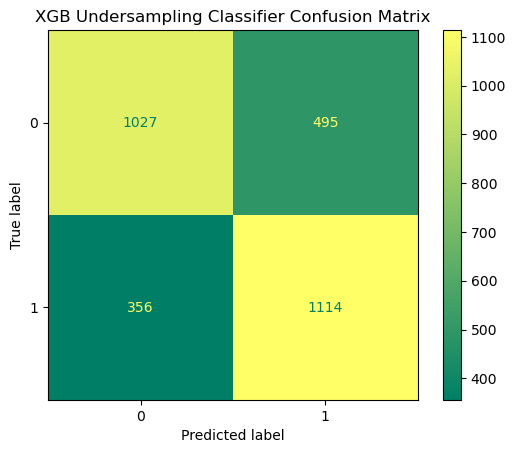

In [76]:
fig = plot_confusion_matrix(XGB_us, X_us_test, y_us_test,  cmap='summer')
plt.title('XGB Undersampling Classifier Confusion Matrix')
plt.show()

## Oversampling

In [54]:
over_sampler = SMOTE(random_state=42) #  SMOTE- Synthetic Minority Oversampling Technique

In [55]:
X = df.drop('booking_complete', axis=1)
X= pd.get_dummies(X)
#X = scale(X)
y = df['booking_complete']

X_over, y_over = over_sampler.fit_resample(X,y)

In [56]:
print(X_over.shape)
print(y_over.shape)

(85044, 917)
(85044,)


In [57]:
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

In [73]:
%%time
RFC_over = RandomForestClassifier(n_estimators=200, random_state =42)
#cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#scoring = ('precision', 'recall', 'f1')
#scores = cross_validate(RFC, X_us, y_us, cv=cv, scoring=scoring)

#Fitting the model
RFC_over.fit(X_over_train, y_over_train)
y_over_pred = RFC_over.predict(X_over_test)
y_over_real = y_over_test.values

print(classification_report(y_over_real, y_over_pred))
print('ACCURACY: ',round(accuracy_score(y_over_real,y_over_pred)*100,2))
print('AUC score: ',round(roc_auc_score(y_over_real,y_over_pred),2))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      8444
           1       0.92      0.88      0.90      8565

    accuracy                           0.90     17009
   macro avg       0.90      0.90      0.90     17009
weighted avg       0.90      0.90      0.90     17009

ACCURACY:  90.0
AUC score:  0.9
Wall time: 1min 37s


C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


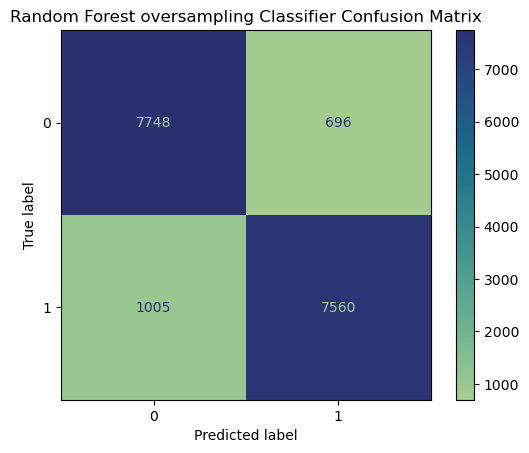

In [59]:
fig = plot_confusion_matrix(RFC_over, X_over_test, y_over_test,  cmap='crest')
plt.title('Random Forest oversampling Classifier Confusion Matrix')
plt.show()

In [74]:
%%time

XGB_over = XGBClassifier()
XGB_over.fit(X_over_train, y_over_train)

y_over_pred = XGB_over.predict(X_over_test)

y_over_real = y_over_test.values

print(classification_report(y_over_real, y_over_pred))
print('ACCURACY: ',round(accuracy_score(y_over_real,y_over_pred)*100,2))
print('AUC score: ',round(roc_auc_score(y_over_real,y_over_pred),2))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      8444
           1       0.90      0.85      0.87      8565

    accuracy                           0.88     17009
   macro avg       0.88      0.88      0.88     17009
weighted avg       0.88      0.88      0.88     17009

ACCURACY:  87.65
AUC score:  0.88
Wall time: 53.6 s


C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


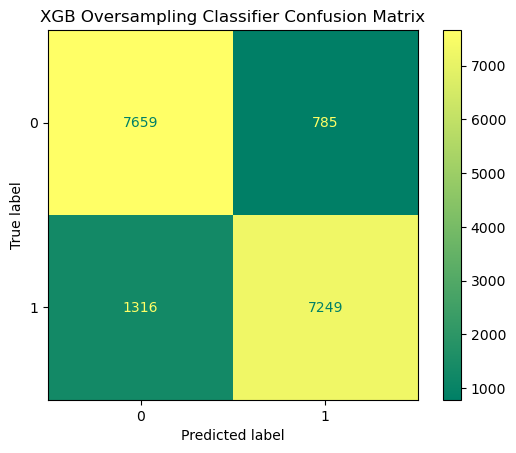

In [77]:
fig = plot_confusion_matrix(XGB_over, X_over_test, y_over_test,  cmap='summer')
plt.title('XGB Oversampling Classifier Confusion Matrix')
plt.show()

## Balanced Random Forrest

In [62]:
X = df.drop('booking_complete', axis=1)
X= pd.get_dummies(X)
y = df['booking_complete']

In [63]:
X.shape

(50000, 917)

In [64]:
y.shape

(50000,)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
BRF= BalancedRandomForestClassifier(n_estimators  = 200, random_state=42)

BRF.fit(X_train, y_train)
y_pred = BRF.predict(X_test)
y_real = y_test.values

print(classification_report(y_real, y_pred))
print('ACCURACY: ',round(accuracy_score(y_real,y_pred)*100,2))
print('AUC score: ',round(roc_auc_score(y_real,y_pred),2))

C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:551: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  FutureWarning,
C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:563: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  FutureWarning,


              precision    recall  f1-score   support

           0       0.95      0.68      0.79      8520
           1       0.30      0.79      0.44      1480

    accuracy                           0.70     10000
   macro avg       0.63      0.73      0.62     10000
weighted avg       0.85      0.70      0.74     10000

ACCURACY:  69.9
AUC score:  0.73


C:\Users\marta.nawrocka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


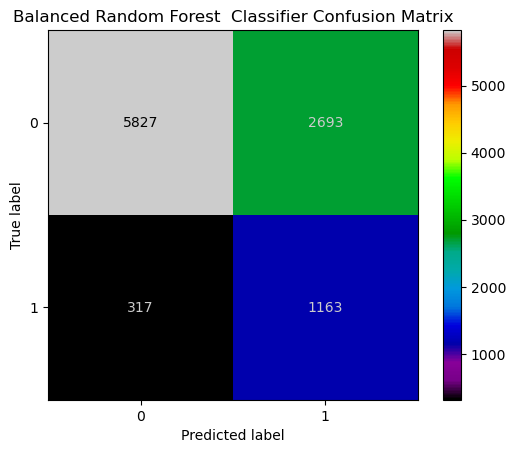

In [68]:
fig = plot_confusion_matrix(BRF, X_test, y_test,  cmap='nipy_spectral')
plt.title('Balanced Random Forest  Classifier Confusion Matrix')
plt.show()